In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data load

In [3]:
tfds.disable_progress_bar() 

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[:20%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(ds_info.features)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

2
['cat', 'dog']


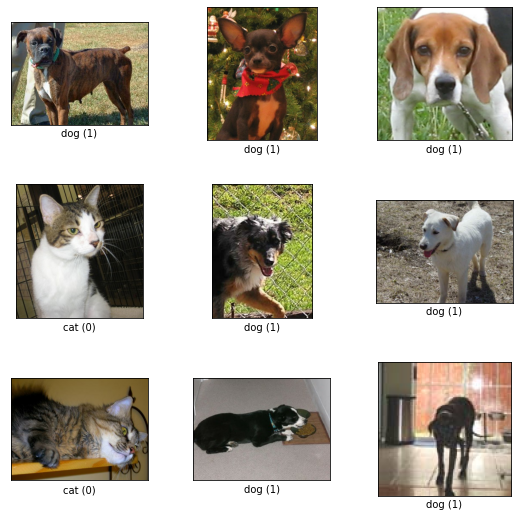

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

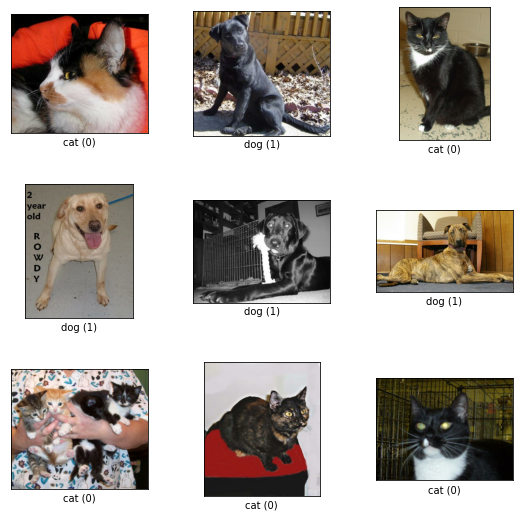

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

## Data Normalization

In [8]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [9]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
BATCH_SIZE = 64
EPOCH = 20

In [11]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

## ResNet-34, ResNet-50 Model Implementation

In [12]:
# Building Conv2_block
def Resnet_Conv2_block(input_layer, channel, kernel_size, strides=1,activation = False):
    
    x = keras.layers.Conv2D(filters=channel, kernel_size=kernel_size,
                            kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',strides=strides)(input_layer)
    x = keras.layers.BatchNormalization()(x)
    if activation == True:
        x = keras.layers.Activation('relu')(x)
    
    return x

In [13]:
# function for building Resnet Block

def build_resnet_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,is_50=False
                   ):
    # 입력 레이어
    x = input_layer
    block_num += 1
    
    if is_50 == False :
        # Resnet34
        for cnn_num in range(num_cnn):
            if block_num > 1 and cnn_num == 0:
                shortcut = Resnet_Conv2_block(x,channel,(1,1),strides = 2)
                x = Resnet_Conv2_block(x,channel,(3,3),strides = 2, activation = True)
                x = Resnet_Conv2_block(x,channel,(3,3))  
            else:
                shortcut = x
                x = Resnet_Conv2_block(x,channel,(3,3),activation = True)
                x = Resnet_Conv2_block(x,channel,(3,3))
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    else:
        # Resnet50
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                if block_num > 1:                    
                    shortcut = Resnet_Conv2_block(x,channel*4,(1,1),strides = 2)
                    x = Resnet_Conv2_block(x,channel,(1,1),strides=2,activation = True)
                    x = Resnet_Conv2_block(x,channel,(3,3),activation = True)
                    x = Resnet_Conv2_block(x,channel*4,(1,1))  
                else:
                    shortcut = Resnet_Conv2_block(x,channel*4,(1,1))
                    x = Resnet_Conv2_block(x,channel,(1,1),activation = True)
                    x = Resnet_Conv2_block(x,channel,(3,3),activation = True)
                    x = Resnet_Conv2_block(x,channel*4,(1,1))                              
            else:
                shortcut = x
                x = Resnet_Conv2_block(x,channel,(1,1),activation = True)
                x = Resnet_Conv2_block(x,channel,(3,3),activation = True)
                x = Resnet_Conv2_block(x,channel*4,(1,1))         
           
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
        
    return x 

In [14]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50=False,activation='softmax'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer


    output = Resnet_Conv2_block(output,64,(7,7),strides = 2,activation = True)
    output = keras.layers.MaxPooling2D(strides = 2)(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,is_50 = is_50
        )
            
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(num_classes, activation=activation)(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
    )
    return model

In [15]:
resnet_34 = build_resnet(input_shape=(224, 224,3),num_classes = 1,is_50=False,activation='sigmoid')
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
resnet_50 = build_resnet(input_shape=(224, 224,3), num_classes = 1,is_50=True,activation='sigmoid')
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

## Plane-34, Plane-50 Model Implementation

In [17]:
# Building Conv2_block
def Plane_Conv2_block(input_layer, channel, kernel_size, strides=1,activation = False):
    
    x = keras.layers.Conv2D(filters=channel, kernel_size=kernel_size,
                            kernel_initializer='he_normal',kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',strides=strides)(input_layer)
    x = keras.layers.BatchNormalization()(x)
    if activation == True:
        x = keras.layers.Activation('relu')(x)
    
    return x

In [18]:
# function for building Plane Block

def build_plane_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,is_50=False
                   ):
    # 입력 레이어
    x = input_layer
    block_num += 1
    
    if is_50 == False :
        # Plane34
        for cnn_num in range(num_cnn):
            if block_num > 1 and cnn_num == 0:
                x = Plane_Conv2_block(x,channel,(3,3),strides = 2, activation = True)
                x = Plane_Conv2_block(x,channel,(3,3))  
            else:
                x = Plane_Conv2_block(x,channel,(3,3),activation = True)
                x = Plane_Conv2_block(x,channel,(3,3))
            
            x = keras.layers.Activation('relu')(x)
    else:
        # Plane50
        for cnn_num in range(num_cnn):
            if cnn_num == 0: 
                x = Plane_Conv2_block(x,channel,(1,1),strides=2,activation = True)
                x = Plane_Conv2_block(x,channel,(3,3),activation = True)
                x = Plane_Conv2_block(x,channel*4,(1,1))                               
            else:
                x = Plane_Conv2_block(x,channel,(1,1),activation = True)
                x = Plane_Conv2_block(x,channel,(3,3),activation = True)
                x = Plane_Conv2_block(x,channel*4,(1,1))         
           
            x = keras.layers.Activation('relu')(x)
        
    return x 

In [19]:
# Resnet 모델 자체를 생성하는 함수입니다.
def build_plane(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50=False,activation='softmax'):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer


    output = Plane_Conv2_block(output,64,(7,7),strides = 2,activation = True)
    output = keras.layers.MaxPooling2D(strides = 2)(output)

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_plane_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,is_50 = is_50
        )
            
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(num_classes, activation=activation)(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output,
    )
    return model

In [20]:
plane_34 = build_plane(input_shape=(224, 224,3),num_classes = 1,is_50=False,activation='sigmoid')
plane_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256 

In [21]:
plane_50 = build_plane(input_shape=(224, 224,3),num_classes = 1,is_50=True,activation='sigmoid')
plane_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 28, 28, 64)        256 

## Ablation Study

In [22]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plane_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plane_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

#epochs = 20

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_plane_34 = plane_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_plane_50 = plane_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 279s 803ms/step - loss: 2.3645 - accuracy: 0.5995 - val_loss: 2.4120 - val_accuracy: 0.5694
Epoch 2/20
290/290 [==============================] - 259s 894ms/step - loss: 2.2984 - accuracy: 0.6770 - val_loss: 2.3033 - val_accuracy: 0.6771
Epoch 3/20
290/290 [==============================] - 228s 788ms/step - loss: 2.2517 - accuracy: 0.7138 - val_loss: 2.4275 - val_accuracy: 0.6254
Epoch 4/20
290/290 [==============================] - 229s 789ms/step - loss: 2.2054 - accuracy: 0.7514 - val_loss: 2.2549 - val_accuracy: 0.7322
Epoch 5/20
290/290 [==============================] - 229s 789ms/step - loss: 2.1371 - accuracy: 0.7932 - val_loss: 2.3476 - val_accuracy: 0.6866
Epoch 6/20
290/290 [==============================] - 229s 789ms/step - loss: 2.0699 - accuracy: 0.8359 - val_loss: 2.0704 - val_accuracy: 0.8314
Epoch 7/20
290/290 [==============================] - 229s 789ms/step - loss: 1.9696 - accuracy: 0.8842 - val_loss: 2.0926 -

## Visualization

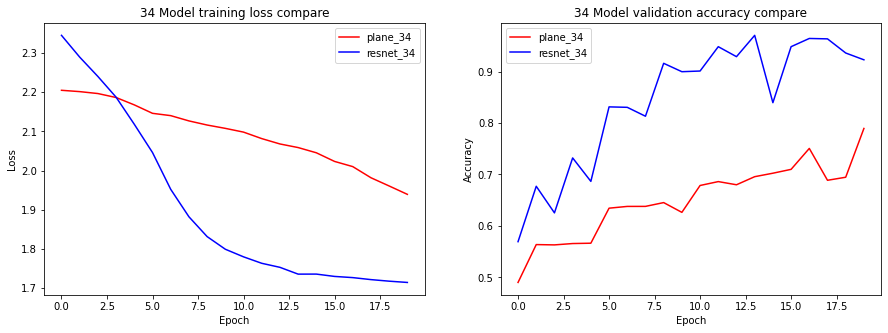

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(history_plane_34.history['loss'], 'r')
plt.plot(history_resnet_34.history['loss'], 'b')
plt.title('34 Model training loss compare')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plane_34', 'resnet_34'])

plt.subplot(1,2,2)
plt.plot(history_plane_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.title('34 Model validation accuracy compare')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plane_34', 'resnet_34'])
plt.show()

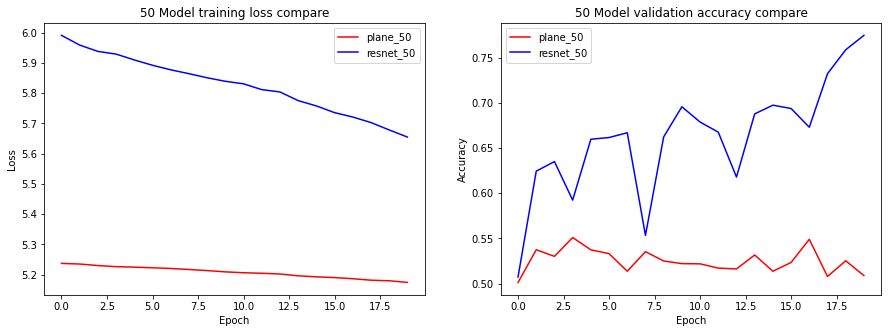

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(history_plane_50.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.title('50 Model training loss compare')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plane_50', 'resnet_50'])

plt.subplot(1,2,2)
plt.plot(history_plane_50.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('50 Model validation accuracy compare')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plane_50', 'resnet_50'])
plt.show()